## GridWorld

In [17]:
from environment import Gridworld

game = Gridworld(size=4, mode='static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [18]:
game.makeMove('d')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', 'P'],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [19]:
game.reward()

-1

In [20]:
player, goal, pit, wall = game.board.render_np()
player, goal, pit, wall

(array([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8),
 array([[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8),
 array([[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8))

## Neural Network Q Function

In [21]:
import numpy as np
import torch
import random
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

In [22]:
def create_model():
    model = torch.nn.Sequential(
        torch.nn.Linear(64, 150),
        torch.nn.ReLU(),
        torch.nn.Linear(150, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 4)
    )
    return model

In [23]:
action_set = {0:'u', 1:'d', 2: 'l', 3:'r'}

In [62]:
def plot_loss(losses):
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

def get_state(game):
    state = game.board.render_np().reshape(1, 64)
    noise = np.random.rand(1, 64)/10.0
    return torch.from_numpy(state + noise).float()

def epsilon_greedy(action_values, epsilon=1.0):
    if random.random() < epsilon:
        return np.random.randint(0, 4)
    return np.argmax(action_values)

def train_model(model, mode='static'):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    gamma = 0.9
    epsilon = 1.0
    epochs = 1_000
    losses = []
    for i in tqdm(range(epochs)):
        # Start a game in each epoch.
        game = Gridworld(size=4, mode=mode)
        state1 = get_state(game)
        while True:
            qval = model(state1)
            qval_ = qval.data.numpy()
    
            # Select an action using epsilon-greedy method.
            action_ = epsilon_greedy(qval_, epsilon=epsilon)
    
            action = action_set[action_]
            game.makeMove(action)
            state2 = get_state(game)
            reward = game.reward()
    
            with torch.no_grad():
                newQ = model(state2.reshape(1, 64))
            maxQ = torch.max(newQ)
            if reward == -1:
                Y = reward + (gamma * maxQ)
            else:
                Y = reward
            Y = torch.Tensor([Y]).detach().squeeze()
            X = qval.squeeze()[action_]
            
            loss = loss_fn(X, Y)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            state1 = state2
            # If the reward is -1, the game hasn't been won or lost 
            # and is still in progress.
            if reward != -1:
                break
        if epsilon > 0.1:
            epsilon -= 1/epochs
    return losses

In [63]:
model = create_model()
losses = train_model(model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.05it/s]


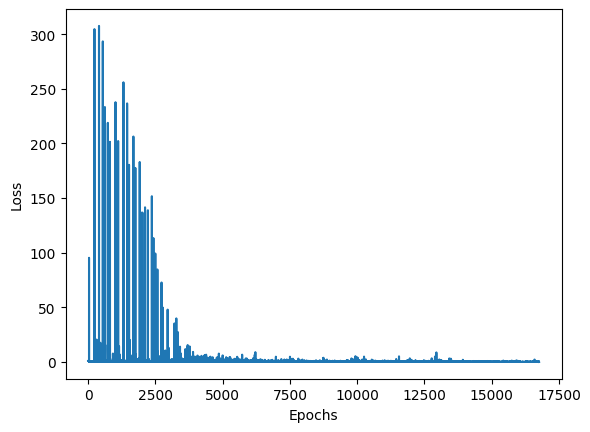

In [65]:
plot_loss(losses)

## Testing

In [72]:
def test_model(model, mode='static', display=True):
    test_game = Gridworld(size=4, mode=mode)
    
    def loop():    
        state = get_state(test_game)
        
        i = 0
        while True:
            qval = model(state)
            qval_ = qval.data.numpy()
            action_ = np.argmax(qval_)
            action = action_set[action_]
            test_game.makeMove(action)
            if display:
                print(f'Move #: {i}; Taking action: {action} {test_game.reward()}')
                print(test_game.display())
            reward = test_game.reward()
            if reward != -1:
                if reward > 0:
                    return f'Game won! Reward: {reward}'
                else:
                    return f'Game lost. Reward: {reward}'
                    
            i += 1
            if i > 15:
                return 'Game lost; too many moves.'
            state = get_state(test_game)
            
    if display:
        print('Initial State:')
        print(test_game.display())
        res = loop()
        print(res)
        return 'won' in res
    else:
        return 'won' in loop()

In [29]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d -1
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l -1
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d -1
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l -1
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l -1
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u -1
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u 10
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


## Random

In [30]:
test_model(model, 'random')

Initial State:
[[' ' '+' ' ' 'W']
 [' ' ' ' ' ' ' ']
 ['P' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: u -1
[[' ' '+' ' ' 'W']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: u -1
[['P' '+' ' ' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: u -1
[['P' '+' ' ' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: u -1
[['P' '+' ' ' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: u -1
[['P' '+' ' ' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u -1
[['P' '+' ' ' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u -1
[['P' '+' ' ' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 7; Taking action: l -1
[['P' '+' ' ' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']]
Move #: 8; Taking action: u -1
[['P' '+' ' '

In [31]:
model = create_model()
losses = train_model(model, 'random')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.19it/s]


Text(0, 0.5, 'Loss')

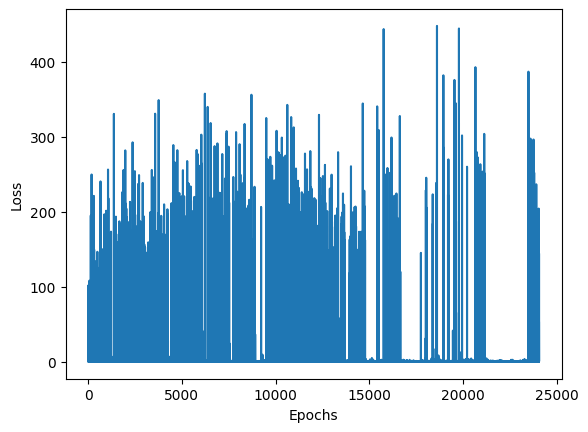

In [32]:
plot_loss(losses)

The loss plot for Q-learning in random model, which doesn't show any sign of convergence.

## Experience Replay

Experience Replay is a technique used in Reinforcement Learning to store the agent's experiences at each time step, then randomly draw a batch of experiences to train the model. This approach has several benefits:

1. **Breaking Correlation**: In a sequential learning process, consecutive experiences can be highly correlated. Training the model on these experiences in order can lead to overfitting. Experience Replay breaks this correlation by randomly sampling experiences from the replay buffer.

2. **Better Utilization of Experiences**: Without Experience Replay, the agent would only learn from each experience once and then discard it. With Experience Replay, the agent can learn from each experience multiple times, which can lead to more efficient learning.

3. **Stabilizing the Learning Process**: By using a replay buffer, the distribution of experiences used for learning is more stable over time than the distribution of on-policy experiences, which can lead to a more stable learning process.

Here's a simple pseudocode for Experience Replay:

```
Initialize replay memory D to capacity N
Initialize action-value function Q with random weights
for episode = 1, M do
    Initialize state s_1
    for t = 1, T do
        With probability ε select a random action a_t
        otherwise select a_t = argmax_a Q(s_t, a; θ)
        Execute action a_t in emulator and observe reward r_t and new state s_{t+1}
        Store transition (s_t, a_t, r_t, s_{t+1}) in D
        Sample random minibatch of transitions (s_j, a_j, r_j, s_{j+1}) from D
        Set y_j = r_j for terminal s_{j+1}
            and y_j = r_j + γ max_a' Q(s_{j+1}, a'; θ) for non-terminal s_{j+1}
        Perform a gradient descent step on (y_j - Q(s_j, a_j; θ))^2
    end for
end for
```

In this pseudocode, `D` is the replay buffer with capacity `N`, `Q` is the action-value function, `s_t` and `a_t` are the state and action at time `t`, `r_t` is the reward, and `y_j` is the target for the Q-learning update. The agent either selects a random action with probability `ε` or the action with the highest estimated reward. The agent stores each experience in `D` and then samples a minibatch from `D` to perform learning.

In [66]:
from collections import deque

def train_model_with_experience_replay(model):
    epochs = 5_000
    losses = []
    mem_size = 1_000
    batch_size = 200
    replay = deque(maxlen=mem_size)
    max_moves = 50
    gamma = 0.9
    h = 0
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for i in tqdm(range(epochs)):
        game = Gridworld(size=4, mode='random')
        state1 = get_state(game)
        mov = 0
        while True:
            mov += 1
            qval = model(state1)
            qval_ = qval.data.numpy()
            action_ = epsilon_greedy(qval_, epsilon=0.1)
            action = action_set[action_]
            game.makeMove(action)

            state2 = get_state(game)
            reward = game.reward()
            done = reward > 0
            exp = (state1, action_, reward, state2, done)
            replay.append(exp)
            state1 = state2

            if len(replay) > batch_size:
                mini_batch = random.sample(replay, batch_size)
                state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in mini_batch]) # Shape: (200, 64)
                action_batch = torch.Tensor([a for (s1, a, r, s2, d) in mini_batch])
                reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in mini_batch])
                state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in mini_batch])
                done_batch = torch.Tensor([d for (s1, a, r, s2, d) in mini_batch])
                Q1 = model(state1_batch)
                with torch.no_grad():
                    Q2 = model(state2_batch) # Shape: (200, 4)
                Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2, dim=1)[0])
                X  = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
                loss = loss_fn(X, Y.detach())
                optimizer.zero_grad()
                loss.backward()
                losses.append(loss.item())
                optimizer.step()
                
            if reward != -1 or mov > max_moves:
                break
    return np.array(losses)

In [67]:
model = create_model()
losses = train_model_with_experience_replay(model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:26<00:00, 34.12it/s]


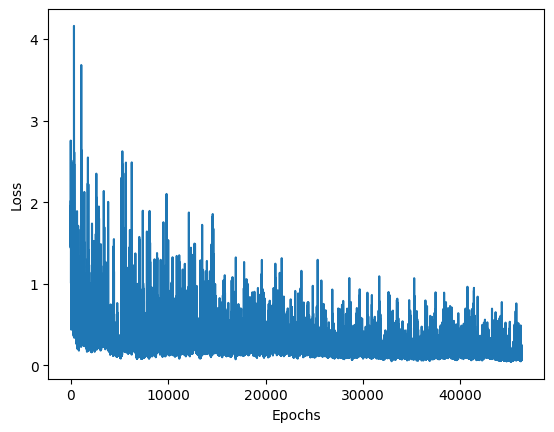

In [68]:
plot_loss(losses)

In [74]:
max_games = 1_000
wins = 0
for i in tqdm(range(max_games)):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_percentage = float(wins) / float(max_games)
print(f'Games played: {max_games}, # of wins: {wins}')
print(f'Win percentage: {win_percentage*100}%')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1145.91it/s]

Games played: 1000, # of wins: 867
Win percentage: 86.7%


## Target Network

In [79]:
from collections import deque

def train_model_with_experience_replay_and_target_network(model, model2):
    epochs = 5_000
    losses = []
    mem_size = 1_000
    batch_size = 200
    replay = deque(maxlen=mem_size)
    max_moves = 50
    gamma = 0.9
    h = 0
    
    sync_freq = 50
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for i in tqdm(range(epochs)):
        game = Gridworld(size=4, mode='random')
        state1 = get_state(game)
        mov = 0
        j = 0
        while True:
            j += 1
            mov += 1
            qval = model(state1)
            qval_ = qval.data.numpy()
            action_ = epsilon_greedy(qval_, epsilon=0.1)
            action = action_set[action_]
            game.makeMove(action)

            state2 = get_state(game)
            reward = game.reward()
            done = reward > 0
            exp = (state1, action_, reward, state2, done)
            replay.append(exp)
            state1 = state2

            if len(replay) > batch_size:
                mini_batch = random.sample(replay, batch_size)
                state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in mini_batch]) # Shape: (200, 64)
                action_batch = torch.Tensor([a for (s1, a, r, s2, d) in mini_batch])
                reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in mini_batch])
                state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in mini_batch])
                done_batch = torch.Tensor([d for (s1, a, r, s2, d) in mini_batch])
                Q1 = model(state1_batch)

                # Uses the target network to get the maximum Q value for the next state.
                with torch.no_grad():
                    Q2 = model2(state2_batch) # Shape: (200, 4)
                Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2, dim=1)[0])
                X  = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
                loss = loss_fn(X, Y.detach())
                optimizer.zero_grad()
                loss.backward()
                losses.append(loss.item())
                optimizer.step()

                if j % sync_freq == 0:
                    model2.load_state_dict(model.state_dict())
                
            if reward != -1 or mov > max_moves:
                break
    return np.array(losses)

In [80]:
import copy

model = create_model()
model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

losses = train_model_with_experience_replay_and_target_network(model, model2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:28<00:00, 33.56it/s]


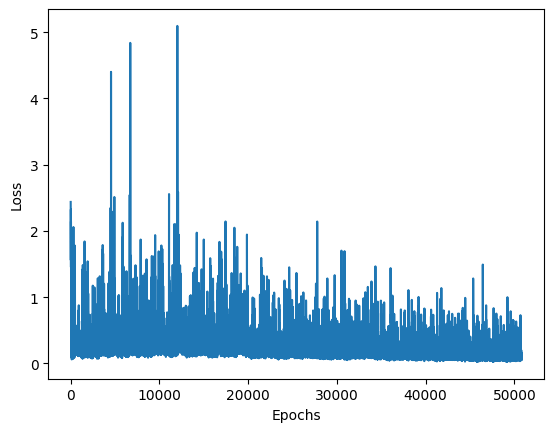

In [81]:
plot_loss(losses)

In [82]:
max_games = 1_000
wins = 0
for i in tqdm(range(max_games)):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_percentage = float(wins) / float(max_games)
print(f'Games played: {max_games}, # of wins: {wins}')
print(f'Win percentage: {win_percentage*100}%')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 753.81it/s]

Games played: 1000, # of wins: 844
Win percentage: 84.39999999999999%
